## <font color = 'blue'>Introduction:</font> What is in this notebook?

This notebook contains code relevant to PunctaFinder users who want to create a validated dataset, determine the optimal threshold values for punctum detection based on such a dataset and visualise the results of the threshold value optimisation.

**The notebook contains the following sections:**

**Section 0:** Load the PunctaFinder module

**Section 1:** Validated dataset creation

**Section 2:** Threshold value optimisation (with bootstrapping)

**Section 3:** Visualising the outcomes


## <font color = 'blue'>Section 0:</font> Load the PunctaFinder module

In [ ]:
import punctafinder as PF

## <font color = 'blue'>Section 1:</font> Validated dataset creation

_Before starting,_ users should determine:
- punctum diameter in px
- overlap parameter (if and how much puncta can overlap with each other)

**step 1:** initiate an empty dataframe

In [3]:
# data frame to store the information
df_validated = pd.DataFrame({})

**step 2a:** visually inspect a single cell

_Approach:_ 

- load fluorescence image and cell mask (array with same size as the microscopy image, indicating all px that belong to the cell of interest);
- visualise this one cell with `plot_masked_cell`.

In [ ]:
# import fluorescence microscopy images and cell masks
cell_mask = io.imread("G:/PATH_TO_IMAGE_FILE/mask.tif")
fluor = io.imread("G:/PATH_TO_IMAGE_FILE/image.tif")

In [ ]:
# visualise the masked cell
PF.plot_masked_cell(fluor, cell_mask)

**step 2b:** determine the number of puncta present

The PunctaFinder can store information on 3 separate categories of puncta.

In this demo, we will make a distinction between:
- **category 1:** the brightest puncta (3 present in example cell 2); 
- **category 2:** dimmer but clear puncta (2 present in example cell 2);
- **category 3:** very dim puncta (1 present in example cell 2).

If you want to use **only 1 category**, simply provide a value of **0** for `N_cat2` and `N_cat3`

In [ ]:
N_cat1 = 3
N_cat2 = 2
N_cat3 = 1

**step 3:** run `PF_validated_data` (_i.e._ PunctaFinder function for dataset creation)with these numbers and visualise the outcome with `plot_PF_validated_data`.

_In this visualisation:_

- Puncta belonging to the 3 categories are shown in different colours: **<font color = 'green'>category 1</font>, <font color = 'red'>category 2</font>, <font color = 'blue'>category 3</font>**;
- The number written on each punctum corresponds to the row in the dataframe that describes this punctum; 
- The 5 brightest non-punctate locations (with the highest average fluorescence intensity) are indicated with a white rectangle and the index of their rows in the dataframe.

The written row numbers **(indices)** can be used to make manual changes in the dataframe with validated data (as demonstrated in **step 4**)

In [ ]:
# run PF for dataset creation
df, cropped_cell, mask_cat1, mask_cat2, mask_cat3 = PF.PF_validated_data(fluor, mask, 3, 0, N_cat1, N_cat2, N_cat3)
# visualise the results
PF.plot_PF_validated_data(df, cropped_cell, mask_cat1, mask_cat2, mask_cat3)

**step 4** _(optional)_**:** make manual changes to the dataframe

Use `df.at[index, "state"] = "desired state"` to make manual changes to the dataframe.

In [ ]:
df.at[2, "state"] = "nonpunctate"

**step 5:** add a unique identifier for this cell to the dataframe.

This identifier is an integer number; the column will be named `cellID`.

This information will be used for bootstrapping in the threshold value optimisation (splitting the total dataset into a training set and a test set).

In [ ]:
if len(df_validated) == 0:
    identifier = 1
else:
    identifiers_used = list(set(list(df_validated["cellID"])))
    identifier = max(identifiers_used) +1
    
df["cellID"] = len(df)*[identifier]

**step 6:** (optional) additional information (more columns) can be added to the dataframe;

use _e.g._ `df["replicate"] = len(df)*["replicateA"]` to add an identifier for the replicate

In [ ]:
df["replicate"] = len(df)*["replicateA"]

**step 7:** add validated data pertaining to 1 cell (`df`) to dataframe with all data (`df_validated`)

In [ ]:
df_validated = pd.concat([df_validated, df])

**step 8:** (once dataset is complete) save the dataframe as a .csv file

In [ ]:
df_validated.to_csv("G:/PATH_TO_LOCATION/validated_dataset_FILENAME.csv")

## <font color = 'blue'>Section 2:</font> Threshold value optimisation
(with bootstrapping)

_Approach:_ 

- Split data set 66%/33% into training and test set. Determine the optimal combination of threshold values based on the training set and apply the obtained thresholds to the test set; 
- Bootstrapping: repeat the whole approach for a **user-defined** number of iterations; 
- Visualise the obtained threshold values, difference in # puncta detected between manual detection and with PunctaFinder, and FP and FN occurrence rates for both training and test set for each bootstrap iteration; 
- For each of the three punctum detection criteria, determine the mean value across the bootstrap iterations so that this value can be used in all further data analysis. 

**step 1:** load the validated dataset

In [4]:
#df_validated = pd.read_csv("G:/PATH_TO_LOCATION/validated_dataset_FILENAME.csv", header = 0, sep = ',')
df_validated = pd.read_csv("G:/Downloads/test_data_threshold_plots.csv", header = 0, sep = ';')

**step 2:** user decisions for threshold optimisation:

- number of bootstrap iterations (`iterations`) that will be performed;
- weighting factor (`FN_weight`) for false negatives within the test statistic according to `test_statistic = #FPs + FN_weight * #FNs`;
- threshold values tested: for each of the three punctum selection criteria, the user sets a minimum value, maximum value and stepsize.

In [5]:
iterations = 5

In [6]:
# test_statistic = FPs + FNs * FN_weight (weighting factor for importance of FN prevention over FP prevention)
# weight < 0: prevention of false positives is valued more than prevention of false negatives
FN_weight = 0.75

In [19]:
# for each criterion create a list with [min_threshold, max_threshold, stepsize]
T_local_vals = [1.5, 3, 0.1]
T_global_vals = [2.5, 8, 0.1]
T_cv_vals = [0.1, 0.5, 0.05]

# create a suitable input for the threshold optimisation function
potential_thresholds = PF.potential_threshold_values(T_local_vals, T_global_vals, T_cv_vals)

**step 3:** define what you want to detect:

Specifically,
- which locations should satisfy the thresholds? These locations are counted as FN if they don't satisfy the applied thresholds;
- which locations should _not_ satifsfy the thresholds? These locations are counted as FP if they do satisfy the applied thresholds.

**For example,** 

when obtaining thresholds to detect the brightest puncta (`category 1`), we could decide we want thresholds stringent enough to exclude all locations labelled `nonpunctate` or `category 3` from detection, but do not mind if some puncta belonging to `category 2` do satisfy all detection criteria.

In [20]:
should_detect = ['category 1']
should_not_detect = ['category 3', 'nonpunctate']

**step 4:** perform the threshold optimisation _(with bootstrapping)_

_How this works:_

- validated dataset is split into training set (66%) and test set (33%);
- all possible combination of threshold values are applied to the training set and every time, a test statistic (`#FPs + FN_weight * #FNs`) is calculated;
- the most stringent combination of threshold values that yields the _minimum value_ for the test statistic is identified.

In [21]:
av_thresholds, N_total, N_training_test, thresholds, differences, errors = PF.thresholds_bootstrap(df_validated, iterations, FN_weight, potential_thresholds, should_detect, should_not_detect) 

iteration 1 finished; obtained threshold values: ratio_local: 2.0000000000000004 ; ratio_global: 6.300000000000003 ; CV: 0.30000000000000004
iteration 2 finished; obtained threshold values: ratio_local: 1.8000000000000003 ; ratio_global: 6.300000000000003 ; CV: 0.30000000000000004
iteration 3 finished; obtained threshold values: ratio_local: 1.8000000000000003 ; ratio_global: 4.100000000000001 ; CV: 0.30000000000000004
iteration 4 finished; obtained threshold values: ratio_local: 2.0000000000000004 ; ratio_global: 6.300000000000003 ; CV: 0.30000000000000004
iteration 5 finished; obtained threshold values: ratio_local: 2.0000000000000004 ; ratio_global: 6.300000000000003 ; CV: 0.30000000000000004

 OBTAINED AVERAGE THRESHOLD VALUES:
ratio_local: 1.9200000000000004
ratio_global: 5.860000000000004
CV: 0.30000000000000004


**step 5:** **<font color = 'red'>manually check</font>** that the obtained threshold values are **<font color = 'red'>NOT</font>** equal to a _minimum_ or _maximum_ of tested threshold values.

**<font color = 'blue'>If</font>** this is the case, **<font color = 'blue'>extend</font>** the range of tested values _(step 2)_ and repeat the analysis _(step 4)_.

## <font color = 'blue'>Section 3:</font> Visualising the outcomes 
of all bootstrap iterations

_The visualisations are:_

- **obtained threshold values** from all bootstrap iterations, with mean value and standard deviation (visualised by small black dot and error bars). The mean values **(for use in further analyses)** are also written above the plot through `print()`;

- **difference between manual punctum detection and PunctaFinder results.** Negative value: algorithm underestimates the number of puncta; positive value: algorithm overestimates the number of puncta;

- **false positive (FP) and false negative (FN) occurrence rates** obtained in each bootstrap iteration for the training and the test set.


**1. visualise the obtained threshold values**

OBTAINED AVERAGE THRESHOLD VALUES:
ratio local: 1.9200000000000004
ratio global: 5.860000000000004
CV: 0.30000000000000004


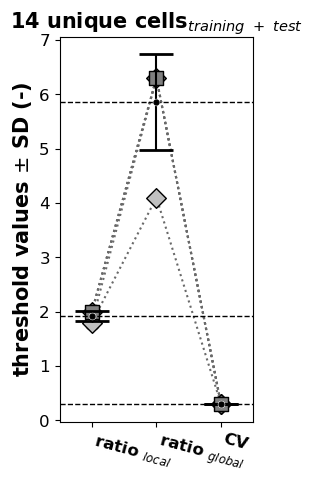

In [24]:
PF.plot_thresholds(thresholds, N_total)

**2. visualise the difference between PunctaFinder results and punctum detection by eye**

_a._ for the _training set_

- first extract the data pertaining to the training set only;
- then make the plot.

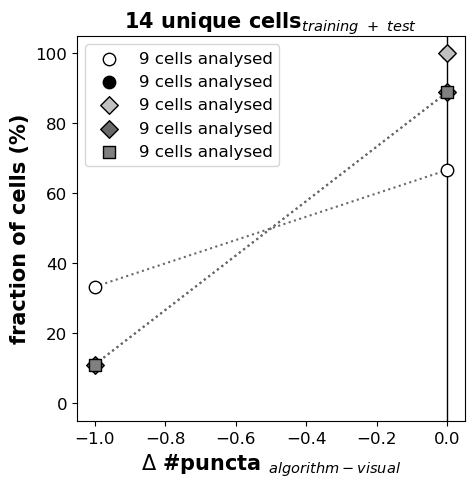

In [28]:
# extract data pertaining to training set
dif_training = differences[0]
N_train = N_training_test[0]

# make the plot
PF.plot_detected_vs_visual(dif_training, N_total, N_train)

_b._ repeat the approach for the _test set_

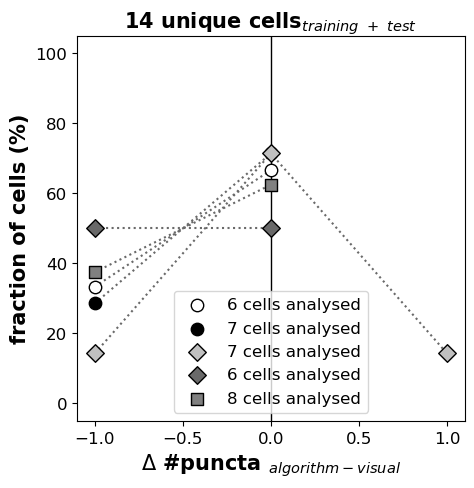

In [47]:
# extract data pertaining to training set
dif_test = differences[1]
N_test = N_training_test[1]

# make the plot
PF.plot_detected_vs_visual(dif_test, N_total, N_test)

**3. visualise the FP and FN occurrence rates**

_a._ for the _training_ set

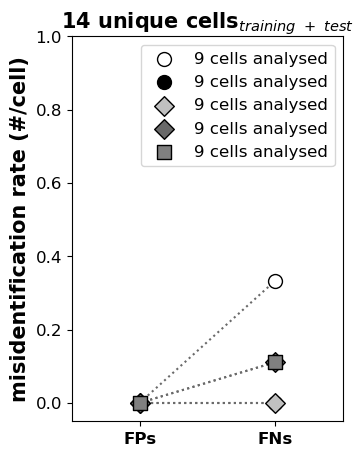

In [44]:
# extract data pertaining to training set
errors_training = errors[0]
N_train = N_training_test[0]

# make the plot
PF.plot_error_rates(errors_training, N_total, N_train)

_b._ for the _test_ set

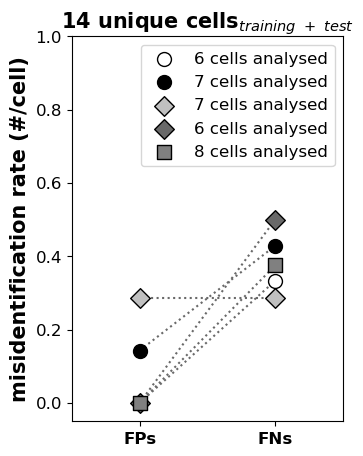

In [48]:
# extract data pertaining to training set
errors_test = errors[1]
N_test = N_training_test[1]

# make the plot
PF.plot_error_rates(errors_test, N_total, N_test)